# 🔄 HMM Regime Dynamics

**Objectif** : Modéliser la dynamique des régimes avec Hidden Markov Model
- Capturer la persistance temporelle des régimes
- Obtenir les probabilités de régime P(regime|data)
- Calculer les probabilités de switch P(switch|t)
- Prédire P(regime(t+1)|regime(t))


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

ROOT = Path("/Users/etienne/Documents/Git/macro-dynamics")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Charger les données


In [3]:
# Charger les données prétraitées
df = pd.read_parquet(ROOT / "data/features/baseline_z.parquet")

# Features z-scorées
z_cols = [c for c in df.columns if c.endswith('_Z')]
print(f"📊 Dataset: {df.shape}")
print(f"Features: {z_cols}")
print(f"Période: {df.index.min()} → {df.index.max()}")

X = df[z_cols].values


📊 Dataset: (359, 23)
Features: ['US10Y_Z', 'US2Y_Z', 'HY_OAS_Z', 'IG_OAS_Z', 'INFLATION_EXP_Z', 'PMI_GAP_Z', 'Unemployment_Z', 'VIX_Z', 'CREDIT_SPREAD_Z', 'Confidence_Z', 'YC_SLOPE_Z']
Période: 1996-01-31 00:00:00 → 2025-11-28 00:00:00


## 2. Sélection du nombre de régimes K


In [4]:
def fit_hmm(X: np.ndarray, n_states: int, n_iter: int = 200) -> hmm.GaussianHMM:
    """Fit un HMM gaussien."""
    model = hmm.GaussianHMM(
        n_components=n_states,
        covariance_type='full',
        n_iter=n_iter,
        random_state=RANDOM_STATE,
        verbose=False
    )
    model.fit(X)
    return model

def compute_bic_aic(model: hmm.GaussianHMM, X: np.ndarray) -> tuple[float, float]:
    """Calcule BIC et AIC pour un HMM."""
    n_samples, n_features = X.shape
    n_states = model.n_components
    
    # Nombre de paramètres
    n_params = (n_states - 1)  # startprob
    n_params += n_states * (n_states - 1)  # transmat
    n_params += n_states * n_features  # means
    n_params += n_states * n_features * (n_features + 1) // 2  # covars (full)
    
    log_likelihood = model.score(X)
    
    bic = -2 * log_likelihood * n_samples + n_params * np.log(n_samples)
    aic = -2 * log_likelihood * n_samples + 2 * n_params
    
    return bic, aic


In [5]:
# Évaluer pour K = 2 à 6
k_range = range(2, 7)
results = []

for k in k_range:
    print(f"Fitting HMM with K={k}...", end=" ")
    model = fit_hmm(X, k)
    bic, aic = compute_bic_aic(model, X)
    log_likelihood = model.score(X) * len(X)
    results.append({'k': k, 'bic': bic, 'aic': aic, 'log_likelihood': log_likelihood})
    print(f"BIC={bic:.0f}, AIC={aic:.0f}")

df_results = pd.DataFrame(results)
df_results


Fitting HMM with K=2... BIC=3314512, AIC=3313903
Fitting HMM with K=3... BIC=2869012, AIC=2868084
Fitting HMM with K=4... BIC=2610658, AIC=2609404
Fitting HMM with K=5... BIC=2373518, AIC=2371930
Fitting HMM with K=6... BIC=2643096, AIC=2641166


,k,bic,aic,log_likelihood
0,2,3.314512e+06,3.313903e+06,-1.656794e+06
1,3,2.869012e+06,2.868084e+06,-1.433803e+06
2,4,2.610658e+06,2.609404e+06,-1.304379e+06
3,5,2.373518e+06,2.371930e+06,-1.185556e+06
4,6,2.643096e+06,2.641166e+06,-1.320086e+06


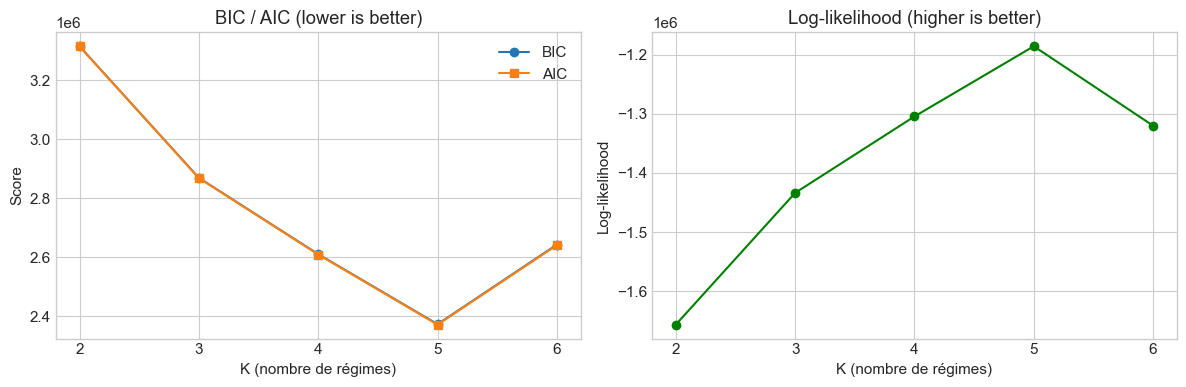


✅ K optimal (BIC): 5


In [6]:
# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(df_results['k'], df_results['bic'], marker='o', label='BIC')
ax.plot(df_results['k'], df_results['aic'], marker='s', label='AIC')
ax.set_xlabel('K (nombre de régimes)')
ax.set_ylabel('Score')
ax.set_title('BIC / AIC (lower is better)')
ax.legend()
ax.set_xticks(list(k_range))

ax = axes[1]
ax.plot(df_results['k'], df_results['log_likelihood'], marker='o', color='green')
ax.set_xlabel('K (nombre de régimes)')
ax.set_ylabel('Log-likelihood')
ax.set_title('Log-likelihood (higher is better)')
ax.set_xticks(list(k_range))

plt.tight_layout()
plt.show()

# K optimal
k_optimal = df_results.loc[df_results['bic'].idxmin(), 'k']
print(f"\n✅ K optimal (BIC): {k_optimal}")


## 3. Fit du modèle HMM final


In [7]:
# Nombre de régimes (ajuster si nécessaire)
N_STATES = 5

# Fit du modèle final
model = hmm.GaussianHMM(
    n_components=N_STATES,
    covariance_type='full',
    n_iter=500,
    random_state=RANDOM_STATE
)
model.fit(X)

print(f"✅ HMM fit avec {N_STATES} régimes")
print(f"Convergé: {model.monitor_.converged}")


✅ HMM fit avec 5 régimes
Convergé: True


In [8]:
# Prédictions: régimes et probabilités
df['regime'] = model.predict(X)
regime_proba = model.predict_proba(X)

# Ajouter les probabilités de chaque régime
for i in range(N_STATES):
    df[f'P_regime_{i}'] = regime_proba[:, i]

# Probabilité du régime actuel
df['regime_proba'] = regime_proba.max(axis=1)

print(f"\nDistribution des régimes:")
print(df['regime'].value_counts().sort_index())



Distribution des régimes:
regime
0     33
1     55
2    128
3     64
4     79
Name: count, dtype: int64


## 4. Matrice de transition


In [9]:
# Matrice de transition apprise par le HMM
transmat = pd.DataFrame(
    model.transmat_,
    index=[f'Régime {i}' for i in range(N_STATES)],
    columns=[f'Régime {i}' for i in range(N_STATES)]
)

print("📊 Matrice de transition P(régime(t+1) | régime(t)):")
transmat


📊 Matrice de transition P(régime(t+1) | régime(t)):


,Régime 0,Régime 1,Régime 2,Régime 3,Régime 4
Régime 0,8.180249e-01,0.030410,1.835348e-47,9.100086e-02,6.056449e-02
Régime 1,3.639314e-02,0.908921,3.651375e-02,9.508575e-66,1.817213e-02
Régime 2,3.280330e-129,0.015796,9.763199e-01,9.528015e-110,7.884286e-03
Régime 3,1.567823e-02,0.015619,1.564817e-02,9.530551e-01,1.945443e-246
Régime 4,2.522579e-02,0.012634,1.263608e-02,9.701239e-309,9.495044e-01


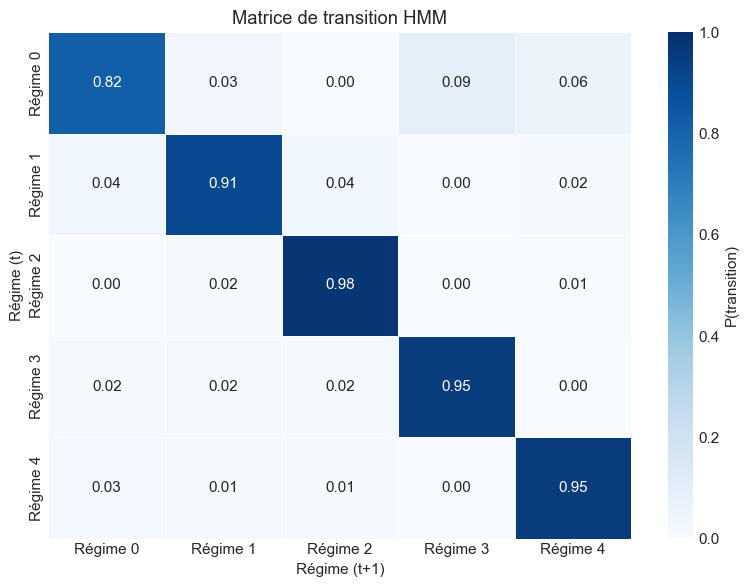


📊 Persistance des régimes (P(rester dans le même régime)):
  Régime 0: 81.8% → durée moyenne: 5.5 mois
  Régime 1: 90.9% → durée moyenne: 11.0 mois
  Régime 2: 97.6% → durée moyenne: 42.2 mois
  Régime 3: 95.3% → durée moyenne: 21.3 mois
  Régime 4: 95.0% → durée moyenne: 19.8 mois


In [10]:
# Heatmap de la matrice de transition
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    transmat,
    cmap='Blues',
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    ax=ax,
    cbar_kws={'label': 'P(transition)'},
    vmin=0, vmax=1
)

ax.set_xlabel('Régime (t+1)')
ax.set_ylabel('Régime (t)')
ax.set_title('Matrice de transition HMM')
plt.tight_layout()
plt.show()

# Persistance (diagonale)
print("\n📊 Persistance des régimes (P(rester dans le même régime)):")
for i in range(N_STATES):
    p = model.transmat_[i, i]
    duration = 1 / (1 - p + 1e-6)
    print(f"  Régime {i}: {p:.1%} → durée moyenne: {duration:.1f} mois")


## 5. Probabilités de régime dans le temps


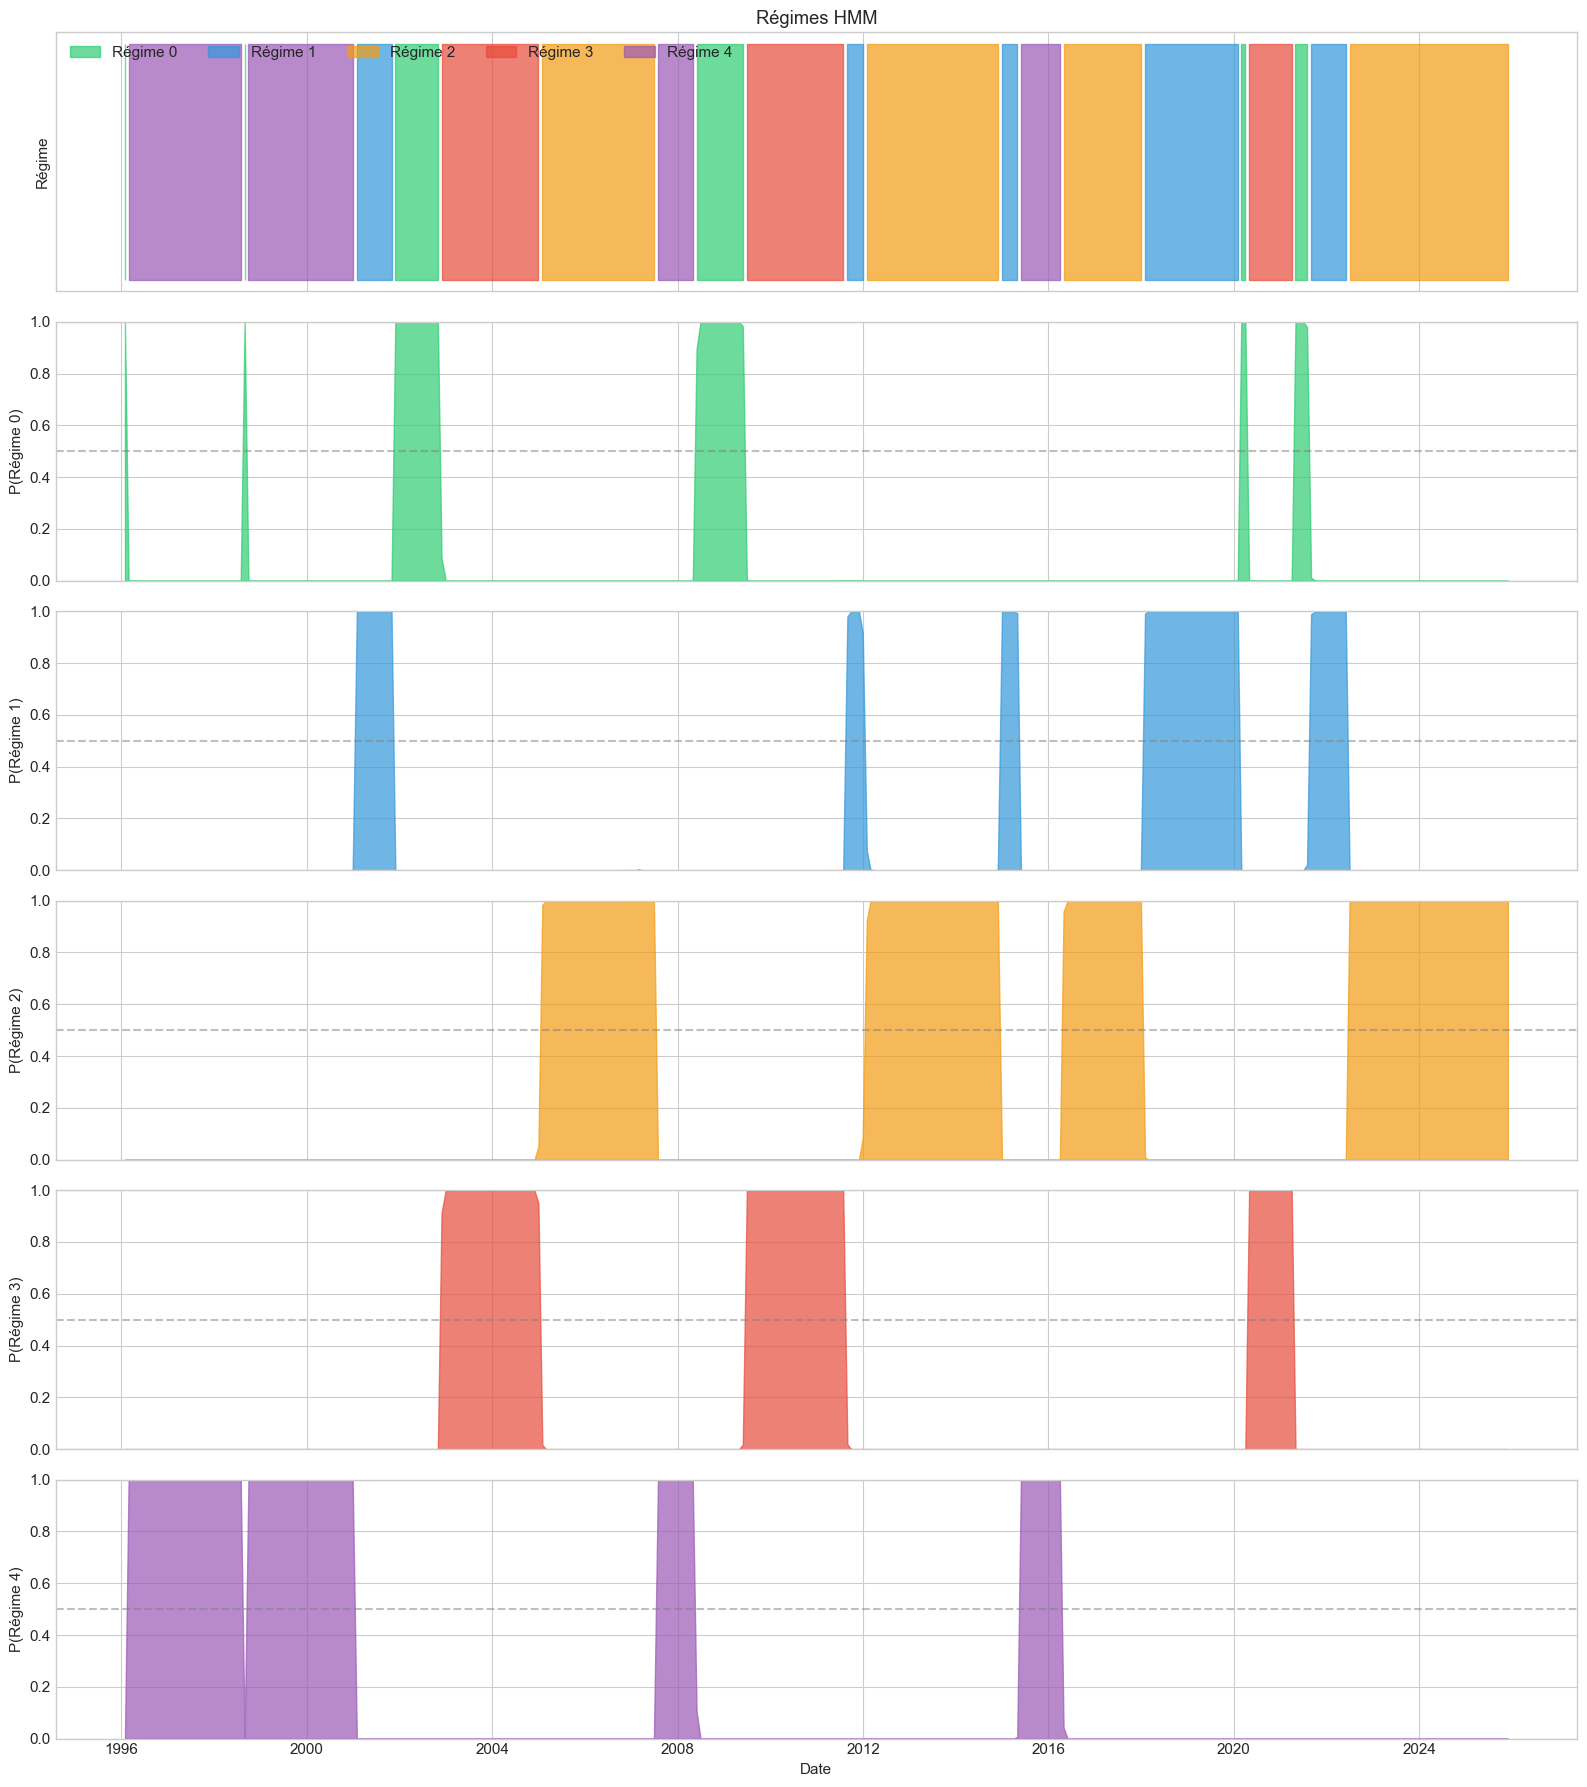

In [11]:
# Couleurs pour les régimes
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#9b59b6', '#1abc9c']

# Visualiser les probabilités de chaque régime
fig, axes = plt.subplots(N_STATES + 1, 1, figsize=(16, 3 * (N_STATES + 1)), sharex=True)

# Timeline des régimes
ax = axes[0]
for regime in range(N_STATES):
    mask = df['regime'] == regime
    ax.fill_between(df.index, 0, 1, where=mask, alpha=0.7, 
                    color=colors[regime], label=f'Régime {regime}')
ax.set_ylabel('Régime')
ax.set_yticks([])
ax.legend(loc='upper left', ncol=N_STATES)
ax.set_title('Régimes HMM')

# Probabilités de chaque régime
for i in range(N_STATES):
    ax = axes[i + 1]
    ax.fill_between(df.index, df[f'P_regime_{i}'], 0, alpha=0.7, color=colors[i])
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylabel(f'P(Régime {i})')
    ax.set_ylim(0, 1)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()


## 6. Probabilité de switch (changement de régime)


In [12]:
def compute_switch_proba(regime_proba: np.ndarray, transmat: np.ndarray) -> np.ndarray:
    """
    Calcule la probabilité de changement de régime au prochain pas de temps.
    
    P(switch|t) = 1 - sum_i P(regime_i|t) * P(regime_i|regime_i)
    """
    n_samples = regime_proba.shape[0]
    switch_proba = np.zeros(n_samples)
    
    for t in range(n_samples):
        # P(rester dans le même régime) = sum_i P(regime_i|t) * P(i→i)
        p_stay = sum(regime_proba[t, i] * transmat[i, i] for i in range(transmat.shape[0]))
        switch_proba[t] = 1 - p_stay
    
    return switch_proba

# Calculer P(switch)
df['switch_proba'] = compute_switch_proba(regime_proba, model.transmat_)

print(f"📊 Statistiques P(switch):")
print(f"  Min: {df['switch_proba'].min():.2%}")
print(f"  Max: {df['switch_proba'].max():.2%}")
print(f"  Mean: {df['switch_proba'].mean():.2%}")


📊 Statistiques P(switch):
  Min: 2.37%
  Max: 18.20%
  Mean: 5.86%


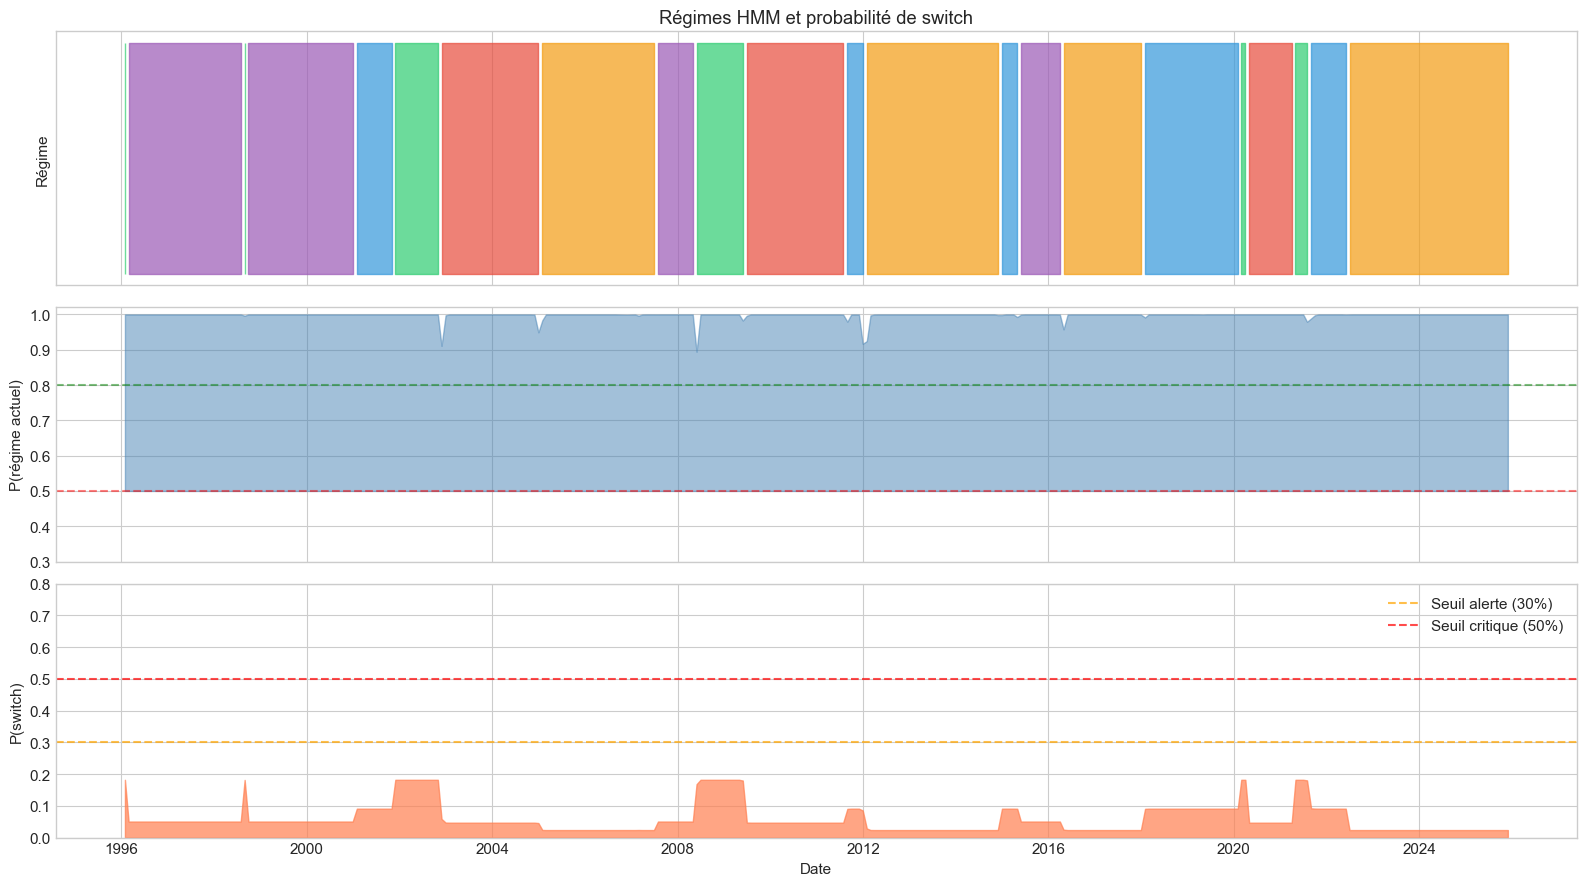

In [13]:
# Visualiser la probabilité de switch
fig, axes = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

# 1. Régimes
ax = axes[0]
for regime in range(N_STATES):
    mask = df['regime'] == regime
    ax.fill_between(df.index, 0, 1, where=mask, alpha=0.7, color=colors[regime])
ax.set_ylabel('Régime')
ax.set_yticks([])
ax.set_title('Régimes HMM et probabilité de switch')

# 2. Confiance dans le régime actuel
ax = axes[1]
ax.fill_between(df.index, df['regime_proba'], 0.5, alpha=0.5, color='steelblue')
ax.axhline(0.5, color='red', linestyle='--', alpha=0.5)
ax.axhline(0.8, color='green', linestyle='--', alpha=0.5)
ax.set_ylabel('P(régime actuel)')
ax.set_ylim(0.3, 1.02)

# 3. Probabilité de switch
ax = axes[2]
ax.fill_between(df.index, df['switch_proba'], 0, alpha=0.7, color='coral')
ax.axhline(0.3, color='orange', linestyle='--', alpha=0.7, label='Seuil alerte (30%)')
ax.axhline(0.5, color='red', linestyle='--', alpha=0.7, label='Seuil critique (50%)')
ax.set_ylabel('P(switch)')
ax.set_xlabel('Date')
ax.set_ylim(0, 0.8)
ax.legend()

plt.tight_layout()
plt.show()


In [22]:
# Identifier les périodes à risque élevé de switch
high_switch_threshold = 0.15
high_switch_periods = df[df['switch_proba'] > high_switch_threshold].copy()

print(f"\n🚨 Périodes avec P(switch) > {high_switch_threshold:.0%}:")
print(f"   {len(high_switch_periods)} mois sur {len(df)} ({len(high_switch_periods)/len(df):.1%})")

print(f"\nDernières alertes:")
high_switch_periods[['regime', 'regime_proba', 'switch_proba']].tail(10)



🚨 Périodes avec P(switch) > 15%:
   33 mois sur 359 (9.2%)

Dernières alertes:


,regime,regime_proba,switch_proba
Date,,,
2009-02-27,0,1.000000,0.181975
2009-03-31,0,1.000000,0.181975
2009-04-30,0,1.000000,0.181975
2009-05-29,0,0.982846,0.179659
2020-02-28,0,1.000000,0.181975
2020-03-31,0,1.000000,0.181975
2021-04-30,0,1.000000,0.181975
2021-05-31,0,1.000000,0.181975
2021-06-30,0,1.000000,0.181975


## 7. Profils économiques des régimes


In [15]:
# Profils basés sur les moyennes du HMM
regime_means = pd.DataFrame(
    model.means_,
    columns=[c.replace('_Z', '') for c in z_cols],
    index=[f'Régime {i}' for i in range(N_STATES)]
)

print("📊 Moyennes des régimes (HMM):")
regime_means


📊 Moyennes des régimes (HMM):


,US10Y,US2Y,HY_OAS,IG_OAS,INFLATION_EXP,PMI_GAP,Unemployment,VIX,CREDIT_SPREAD,Confidence,YC_SLOPE
Régime 0,-1.661033,-1.736498,2.048385,2.083234,0.605098,-1.009234,-1.998574,1.761601,1.998947,-1.576886,1.449381
Régime 1,-0.311432,0.275207,-0.134543,-0.094713,1.334840,-0.247403,0.806835,0.354821,-0.180128,-0.328492,-0.354888
Régime 2,0.318089,0.943347,-0.744409,-0.709434,0.393343,-0.063159,0.914663,-0.801561,-0.946014,0.118006,-0.938498
Régime 3,-1.269161,-1.339696,-0.301580,-0.472537,-1.842973,0.733491,-1.761584,-0.145116,-0.066464,-0.946941,1.089394
Régime 4,-0.632859,0.122641,0.543223,0.987787,-0.830700,-0.282978,1.420529,1.031878,0.937379,0.922617,-0.942500


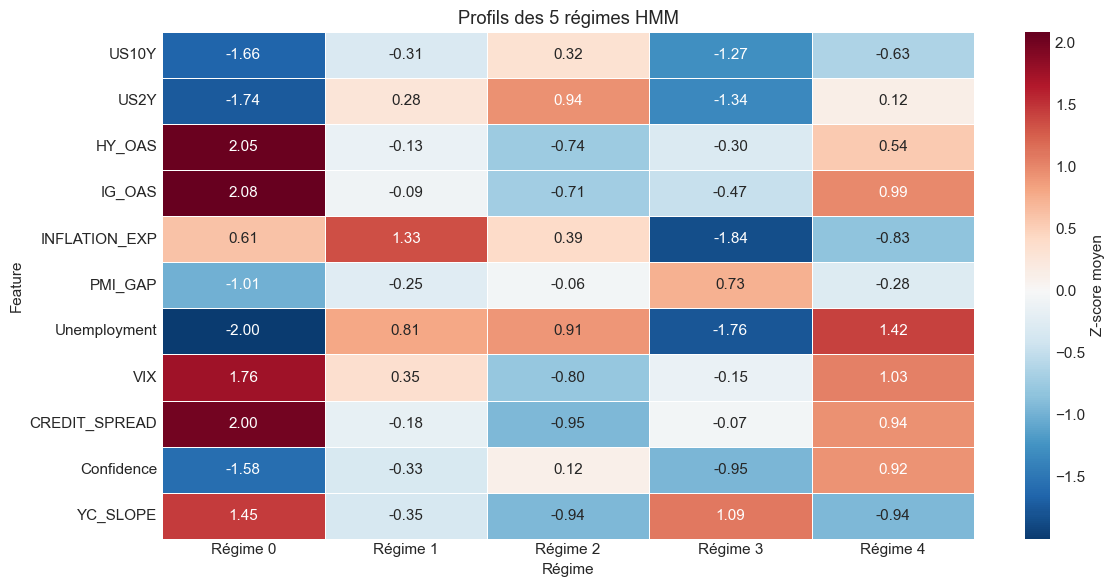

In [16]:
# Heatmap des profils HMM
fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(
    regime_means.T,
    cmap='RdBu_r',
    center=0,
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    ax=ax,
    cbar_kws={'label': 'Z-score moyen'}
)

ax.set_xlabel('Régime')
ax.set_ylabel('Feature')
ax.set_title(f'Profils des {N_STATES} régimes HMM')
plt.tight_layout()
plt.show()


In [17]:
# Interprétation des régimes
def interpret_regime(means: pd.Series) -> str:
    signals = []
    if means.get('VIX', 0) > 1: signals.append("🔴 Stress élevé")
    elif means.get('VIX', 0) < -0.5: signals.append("🟢 Faible volatilité")
    if means.get('HY_OAS', 0) > 1: signals.append("💰 Spreads larges")
    elif means.get('HY_OAS', 0) < -0.5: signals.append("💰 Spreads serrés")
    if means.get('YC_SLOPE', 0) < -1: signals.append("📉 Courbe inversée")
    elif means.get('YC_SLOPE', 0) > 1: signals.append("📈 Courbe pentue")
    if means.get('PMI_GAP', 0) < -1: signals.append("🏭 Contraction")
    elif means.get('PMI_GAP', 0) > 1: signals.append("🏭 Expansion")
    if means.get('Confidence', 0) < -1: signals.append("😟 Confiance faible")
    elif means.get('Confidence', 0) > 1: signals.append("😊 Confiance élevée")
    return ' | '.join(signals) if signals else "⚪ Neutre"

print("\n🏷️ Interprétation des régimes HMM:")
print("=" * 70)
for i in range(N_STATES):
    means = regime_means.loc[f'Régime {i}']
    interpretation = interpret_regime(means)
    count = (df['regime'] == i).sum()
    pct = count / len(df) * 100
    print(f"\nRégime {i} ({count} mois, {pct:.1f}%):")
    print(f"  {interpretation}")



🏷️ Interprétation des régimes HMM:

Régime 0 (33 mois, 9.2%):
  🔴 Stress élevé | 💰 Spreads larges | 📈 Courbe pentue | 🏭 Contraction | 😟 Confiance faible

Régime 1 (55 mois, 15.3%):
  ⚪ Neutre

Régime 2 (128 mois, 35.7%):
  🟢 Faible volatilité | 💰 Spreads serrés

Régime 3 (64 mois, 17.8%):
  📈 Courbe pentue

Régime 4 (79 mois, 22.0%):
  🔴 Stress élevé


## 8. Prédiction forward: P(régime(t+1) | data jusqu'à t)


In [23]:
def predict_next_regime_proba(current_proba: np.ndarray, transmat: np.ndarray) -> np.ndarray:
    """Prédit P(régime(t+1)) sachant P(régime(t))."""
    return current_proba @ transmat

# Prédire les probabilités pour le prochain mois
next_regime_proba = predict_next_regime_proba(regime_proba, model.transmat_)

for i in range(N_STATES):
    df[f'P_next_regime_{i}'] = next_regime_proba[:, i]

# Dernière observation: état actuel et prédiction
print("📊 Dernière observation:")
print(f"   Date: {df.index[-1]}")
print(f"   Régime actuel: {df['regime'].iloc[-1]}")
print(f"   P(régime actuel): {df['regime_proba'].iloc[-1]:.1%}")
print(f"   P(switch next month): {df['switch_proba'].iloc[-1]:.1%}")

print("\n🔮 Prédiction pour le prochain mois:")
for i in range(N_STATES):
    p = next_regime_proba[-1, i]
    print(f"   P(Régime {i}): {p:.1%}")


📊 Dernière observation:
   Date: 2025-11-28 00:00:00
   Régime actuel: 2
   P(régime actuel): 100.0%
   P(switch next month): 2.4%

🔮 Prédiction pour le prochain mois:
   P(Régime 0): 0.0%
   P(Régime 1): 1.6%
   P(Régime 2): 97.6%
   P(Régime 3): 0.0%
   P(Régime 4): 0.8%


## 9. Dashboard récapitulatif


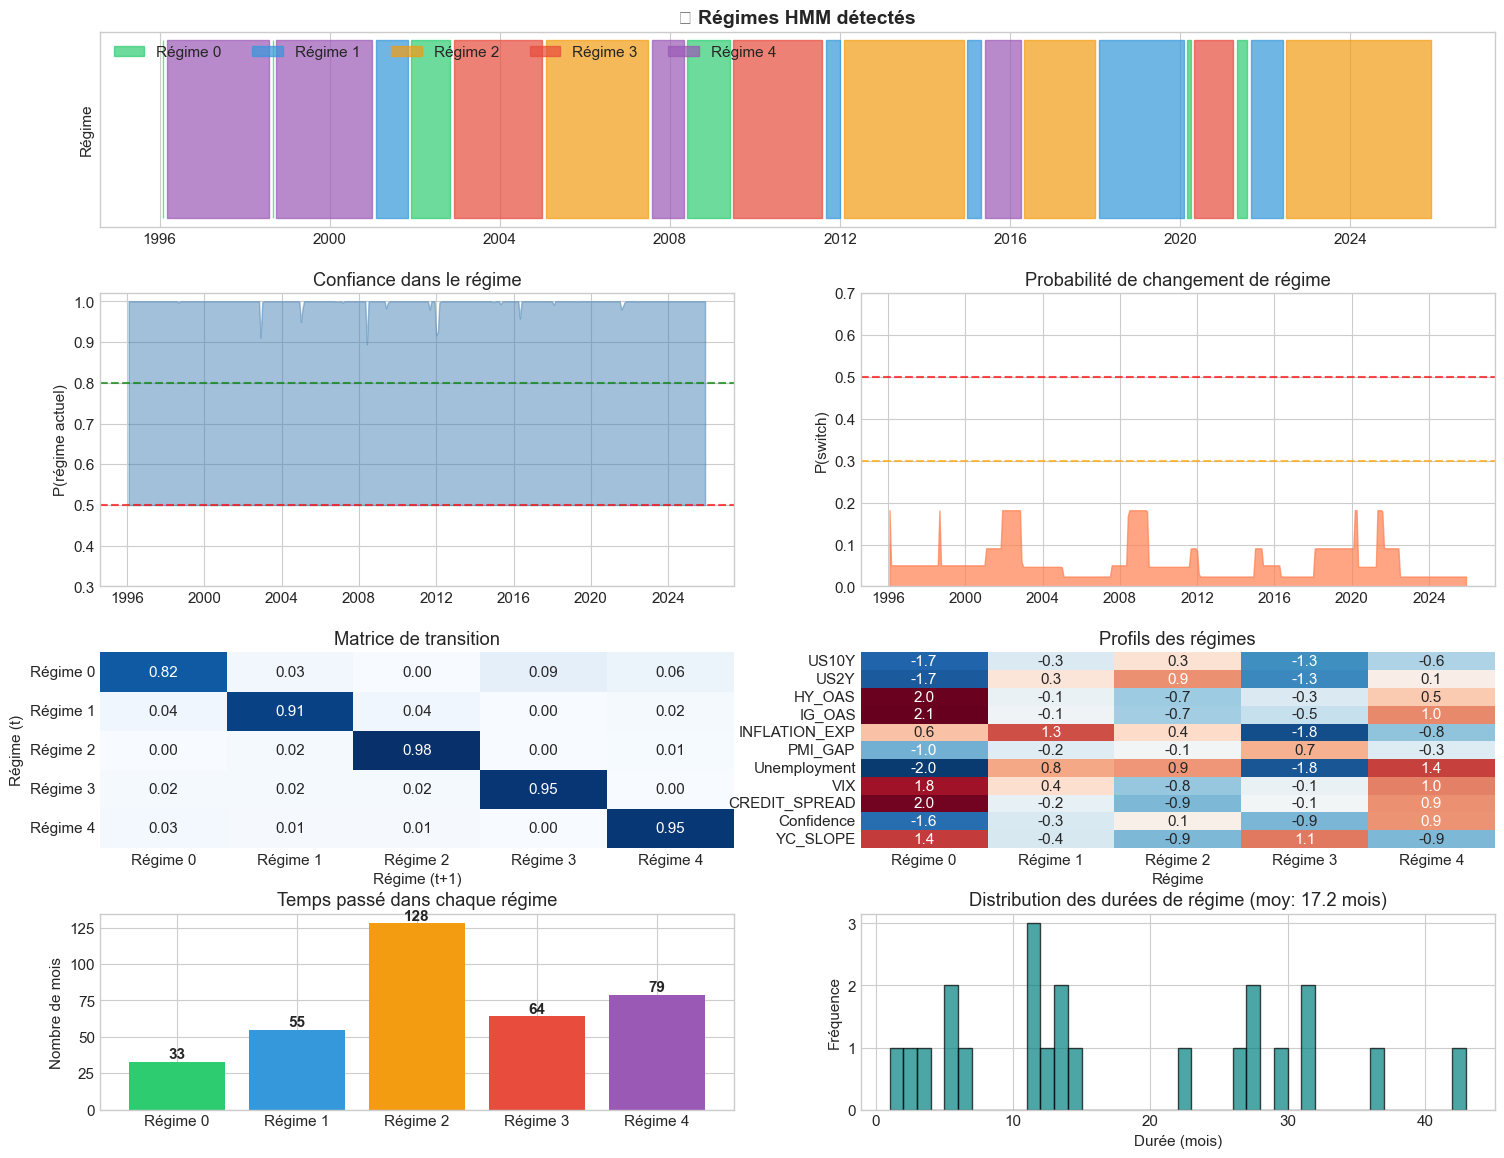


✅ Dashboard sauvegardé: reports/hmm_dashboard.png


In [ ]:
# Dashboard final
fig = plt.figure(figsize=(18, 14))

# Layout: 4 lignes
gs = fig.add_gridspec(4, 2, height_ratios=[1, 1.5, 1, 1], hspace=0.3)

# 1. Timeline des régimes (full width)
ax1 = fig.add_subplot(gs[0, :])
for regime in range(N_STATES):
    mask = df['regime'] == regime
    ax1.fill_between(df.index, 0, 1, where=mask, alpha=0.7, 
                     color=colors[regime], label=f'Régime {regime}')
ax1.set_ylabel('Régime')
ax1.set_yticks([])
ax1.legend(loc='upper left', ncol=N_STATES)
ax1.set_title('🔄 Régimes HMM détectés', fontsize=14, fontweight='bold')

# 2a. Confiance
ax2a = fig.add_subplot(gs[1, 0])
ax2a.fill_between(df.index, df['regime_proba'], 0.5, alpha=0.5, color='steelblue')
ax2a.axhline(0.8, color='green', linestyle='--', alpha=0.7)
ax2a.axhline(0.5, color='red', linestyle='--', alpha=0.7)
ax2a.set_ylabel('P(régime actuel)')
ax2a.set_ylim(0.3, 1.02)
ax2a.set_title('Confiance dans le régime')

# 2b. Probabilité de switch
ax2b = fig.add_subplot(gs[1, 1])
ax2b.fill_between(df.index, df['switch_proba'], 0, alpha=0.7, color='coral')
ax2b.axhline(0.3, color='orange', linestyle='--', alpha=0.7)
ax2b.axhline(0.5, color='red', linestyle='--', alpha=0.7)
ax2b.set_ylabel('P(switch)')
ax2b.set_ylim(0, 0.7)
ax2b.set_title('Probabilité de changement de régime')

# 3. Matrice de transition
ax3a = fig.add_subplot(gs[2, 0])
sns.heatmap(transmat, cmap='Blues', annot=True, fmt='.2f', ax=ax3a, cbar=False)
ax3a.set_title('Matrice de transition')
ax3a.set_xlabel('Régime (t+1)')
ax3a.set_ylabel('Régime (t)')

# 4. Profils des régimes
ax3b = fig.add_subplot(gs[2, 1])
sns.heatmap(regime_means.T, cmap='RdBu_r', center=0, annot=True, fmt='.1f', ax=ax3b, cbar=False)
ax3b.set_title('Profils des régimes')
ax3b.set_xlabel('Régime')

# 5. Distribution temps dans chaque régime
ax4a = fig.add_subplot(gs[3, 0])
regime_counts = df['regime'].value_counts().sort_index()
bars = ax4a.bar(range(N_STATES), regime_counts.values, color=colors[:N_STATES])
ax4a.set_xticks(range(N_STATES))
ax4a.set_xticklabels([f'Régime {i}' for i in range(N_STATES)])
ax4a.set_ylabel('Nombre de mois')
ax4a.set_title('Temps passé dans chaque régime')
for bar, count in zip(bars, regime_counts.values):
    ax4a.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count}', 
              ha='center', va='bottom', fontweight='bold')

# 6. Distribution durées des régimes
ax4b = fig.add_subplot(gs[3, 1])
regime_changes = df['regime'].diff().fillna(0) != 0
regime_starts = df.index[regime_changes | (df.index == df.index[0])]
# Calculate durations in months by converting timedelta to days then dividing by ~30
regime_durations_td = np.diff(list(regime_starts) + [df.index[-1]])
regime_durations = np.array([td.days // 30 for td in regime_durations_td]) + 1
ax4b.hist(regime_durations, bins=range(1, max(regime_durations)+2), 
          color='teal', alpha=0.7, edgecolor='black')
ax4b.set_xlabel('Durée (mois)')
ax4b.set_ylabel('Fréquence')
ax4b.set_title(f'Distribution des durées de régime (moy: {np.mean(regime_durations):.1f} mois)')

plt.tight_layout()
plt.savefig(ROOT / 'reports/hmm_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Dashboard sauvegardé: reports/hmm_dashboard.png")


## 10. Export des résultats


In [20]:
# Sauvegarder les résultats
output_cols = z_cols + ['regime', 'regime_proba', 'switch_proba'] + \
              [f'P_regime_{i}' for i in range(N_STATES)] + \
              [f'P_next_regime_{i}' for i in range(N_STATES)]

df_output = df[output_cols].copy()
output_path = ROOT / "data/features/hmm_regimes.parquet"
df_output.to_parquet(output_path)
print(f"✅ Résultats HMM sauvegardés: {output_path}")

# Sauvegarder les paramètres du modèle
import pickle
model_path = ROOT / "regime_models/hmm_model.pkl"
model_path.parent.mkdir(parents=True, exist_ok=True)
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"✅ Modèle HMM sauvegardé: {model_path}")


✅ Résultats HMM sauvegardés: /Users/etienne/Documents/Git/macro-dynamics/data/features/hmm_regimes.parquet
✅ Modèle HMM sauvegardé: /Users/etienne/Documents/Git/macro-dynamics/regime_models/hmm_model.pkl


## 📋 Résumé

**Outputs disponibles chaque mois:**

| Variable | Description |
|----------|-------------|
| `regime` | Régime le plus probable (0 à K-1) |
| `regime_proba` | Confiance P(régime actuel) |
| `switch_proba` | P(changement de régime le mois prochain) |
| `P_regime_i` | Probabilité d'être dans le régime i |
| `P_next_regime_i` | Probabilité d'être dans le régime i le mois prochain |

**Prochaines étapes:**
1. Backtesting: performance des stratégies par régime
2. Walk-forward validation: stabilité du modèle
3. Online learning: mise à jour mensuelle du modèle
